# Basic Oscillator to test numerical schemes

Staring with a very simple oscillator to test the accuracy and robustness of our numerical schemes before applying them to more complex problems.

$$
\frac{dv}{dt} = - x
$$
$$
\frac{dx}{dt} = v
$$

Spring constant = 1
Energy is a conserved quantity

$$
E = x^2 + v^2
$$

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
HTML( open('my_css.css').read() )

In [2]:
##Define the equations as functions for use in the program

def func_dvdt(x):       #dv/dt = -x
    return -x
def func_dxdt(v):       #dx/dt = v
    return v
def func_ddt(q):
    return np.array([q[1],-q[0]])
def func_nrgCons(x,v):    #E = x^2 + v^2
    nrgConsVal = (x**2 + v**2)
    return nrgConsVal

# Schemes:

### 1st Order : Euler Forwards

$$\phi_{n+1} = \phi_n + \Delta tf(\phi_n)$$

### 1st Order : Forwards-Backwards

$$\phi_{n+1} = \phi_n + \Delta tf(\phi_n + \Delta tf(\phi_n))$$

### 2nd Order : Leapfrog

$$\phi_{n+1} = \phi_{n-1} + 2\Delta tf(\phi_n)$$

### 4th Order : Runge - Kutta (4-step explicit)

$$\phi_{n+1} = \phi_n + \frac{(\Delta tf(\phi_n) + 2\Delta tf(\phi_n + \frac{\Delta tf(\phi_n)}{2}) + 2\Delta tf(\phi_n + \frac{\Delta tf(\phi_n + \frac{\Delta tf(\phi_n)}{2})}{2}) + \Delta tf(\phi_n + \Delta tf(\phi_n + \frac{\Delta tf(\phi_n + \frac{\Delta tf(\phi_n)}{2})}{2}))}{6}$$

$\phi$ will be represented by q in the code below (q = quantity)

In [3]:
# dqdt is a list of the stored time derivatives for q, stored in order from present to the past
#ie. f(q_n) = dqdt[0] ; f(q_n-1) = dqdt[1] ;...

#phi_... = q, delta t = dt, f(...) = dqdt[...]

#q is either x or v

###Euler Forwards
def euler1(q,dt,func):
    return np.array(q + dt*func(q))

###Forwards-Backwards
def forback(q,dt,func): 
    return q + dt*func(q+dt*func(q))
    
###Leapfrog
#Since leapfrog uses q_(n-1), we need to use a different scheme for the first time step as there is no q_(n-1)
#In this case we use the Euler Forwards scheme    
def leapfrog(q,dt,func):
    return np.array(q + 2*dt*func(q))

###Adams Bashforth --- UNUSED FOR VARIABLE DUE TO COMPLEXITY IN REDERIVATION  
#Since 3rd order Adams Bashforth uses dqdt_(n-1) and dqdt(n-2), we need to use a different scheme for the first two time steps
#In this case we can use the first and second order Adams Bashforth schemes for the first and second steps respectivley
#def AdbA(q,dt,dqdt,order):
#    if order == 3:
#        #return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12
#        return (q + (dt/12)*(23*dqdt[0]-16*dqdt[1]+5*dqdt[2]))
#    elif order == 2:
#        #return (3*dqdt[0] - dqdt[1])/2
#        return (q + (dt/2)*(3*dqdt[0] - dqdt[1]))
#    elif order == 1:
#        #return dqdt[0]
#        return (q + dt*dqdt[0])

###Runge-Kutta
def RK(dt,q,func): 
    s1 = dt*func(q)
    s2 = dt*func(q+s1/2)
    s3 = dt*func(q+s2/2)
    s4 = dt*func(q+s3)
    #print(s1,s2,s3,s4)
    return np.array(q + (s1 + 2*s2 + 2*s3 + s4)/6)

In [4]:
#Testing.
#Let i and j be junk, and djdt to the list of time derivatives of j, at the current time step, previous time step and the 
#time step before that:
#i = 2.0
#j = 1.0
#dt = 0.1
#djdt = [1.0,1.1,1.4]
#leapfrog_1(j,dt,djdt)
#leapfrog(j,dt,djdt)
#AdbA(j,dt,djdt,1)
#AdbA(j,dt,djdt,2)
#AdbA(j,dt,djdt,3)
#RK(dt,i,func_dxdt)
#RK(dt,j,func_dvdt)

In [5]:
#Testing.
#Keeping djdt only 3 items long while updating to have the most recent time step first
#djdt = [1.0,1.1,1.4]
      #[ n ,n-1,n-2]
#djdt = [.9] + djdt[:-1]
#djdt = [.5] + djdt[:-1]
#djdt

In [6]:
#Euler forwards time stepper
def onestep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1)
    AccxArr,AccvArr = np.zeros(noStep +1),np.zeros(noStep +1)
    tArr[0],xArr[0],vArr[0],conArr[0] = t,x,v,func_nrgCons(x,v)
    AccxArr[0] = x
    AccvArr[0] = v
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep+1):
        xvArr = euler1(xvArr,tStep,func_ddt)
        t += tStep    
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
        AccxArr[stepNo] = math.cos(t)
        AccvArr[stepNo] = -math.sin(t)
    return conArr,xArr,vArr,tArr,AccxArr,AccvArr
        

#Forwards-Backwards time stepper
def twostep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1)
    AccxArr,AccvArr = np.zeros(noStep +1),np.zeros(noStep +1)
    tArr[0],xArr[0],vArr[0],conArr[0] = t,x,v,func_nrgCons(x,v)
    AccxArr[0] = x
    AccvArr[0] = v
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep+1):
        xvArr = forback(xvArr,tStep,func_ddt)
        #print(xvArr)
        t += tStep    
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
        AccxArr[stepNo] = math.cos(t)
        AccvArr[stepNo] = -math.sin(t)
    return conArr,xArr,vArr,tArr,AccxArr,AccvArr
    
    
#Leapfrog time stepper
def threestep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1)
    AccxArr,AccvArr = np.zeros(noStep +1),np.zeros(noStep +1)
    tArr[0],xArr[0],vArr[0],conArr[0] = t,x,v,func_nrgCons(x,v)
    AccxArr[0] = x
    AccvArr[0] = v
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep+1):
        if stepNo != 2:
            xvArr = leapfrog([xArr[stepNo-1],vArr[stepNo-1]],tStep,func_ddt)
        else:
            xvArr = euler1(xvArr,tStep,func_ddt)
        t += tStep    
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
        AccxArr[stepNo] = math.cos(t)
        AccvArr[stepNo] = -math.sin(t)
    return conArr,xArr,vArr,tArr,AccxArr,AccvArr
    
#Runge-Kutta (4-Step) time stepper
def fourstep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1),np.zeros(noStep +1)
    AccxArr,AccvArr = np.zeros(noStep +1),np.zeros(noStep +1)
    tArr[0],xArr[0],vArr[0],conArr[0]= t,x,v,func_nrgCons(x,v)
    AccxArr[0] = x
    AccvArr[0] = v
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep+1):
        #print(xvArr)
        xvArr = RK(tStep,xvArr,func_ddt)
        #print([1,0]-xvArr)
        t += tStep  
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
        AccxArr[stepNo] = math.cos(t)
        AccvArr[stepNo] = -math.sin(t)
    return conArr,xArr,vArr,tArr,AccxArr,AccvArr

In [19]:
##### THESE ARRAYS ARE DEFINED FOR THE COMPARISON PLOT AT THE END OF THIS SECTION
##### DO NOT RUN THIS AT THE START OF EACH EXPERIMENT UNLESS YOU WANT TO EMPTY THE ARRAYS
eulerArr = np.zeros(10)
fbArr = np.zeros(10)
lfArr = np.zeros(10)
rkArr = np.zeros(10)
stepArr = np.zeros(10)
ticker = 0
print(eulerArr,fbArr,lfArr,rkArr,stepArr,ticker)
#TO MAINTAIN SAME TIME STEP FOR EACH RUN - KEEP timestop AT 10*math.pi AND CHANGE nsteps IN THE FOLLOWING ORDER:
# 100,250,500,750,1000,1500,2000,5000,10000,50000
# KEEP START CONDITIONS THE SAME : x=1, v=0

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 0


# Start Here for Experiments

In [347]:
#define stuff
nsteps = 50000
timestop = 10*math.pi
scheme =  4   #1 = Euler Forwards, 2 = Forwards-Backwards, 3 = Leapfrog, 4 = Runge-Kutta (4-Step)
initialX = 1.0
initialV = 0.0
timestep = timestop/nsteps
print("The time step is",timestep)

The time step is 0.0006283185307179586


In [348]:
if scheme == 1:
    plotC,plotX,plotV,plotT,plotAX,plotAV = onestep(initialX,initialV,timestop,timestep,nsteps)
elif scheme == 2:
    plotC,plotX,plotV,plotT,plotAX,plotAV = twostep(initialX,initialV,timestop,timestep,nsteps)
elif scheme == 3:
    plotC,plotX,plotV,plotT,plotAX,plotAV = threestep(initialX,initialV,timestop,timestep,nsteps)
elif scheme == 4:
    plotC,plotX,plotV,plotT,plotAX,plotAV = fourstep(initialX,initialV,timestop,timestep,nsteps)
else:
    print("No scheme of the order "+scheme+" has been implemented")
print("No. Steps taken was",len(plotX)-1,"steps")

No. Steps taken was 50000 steps


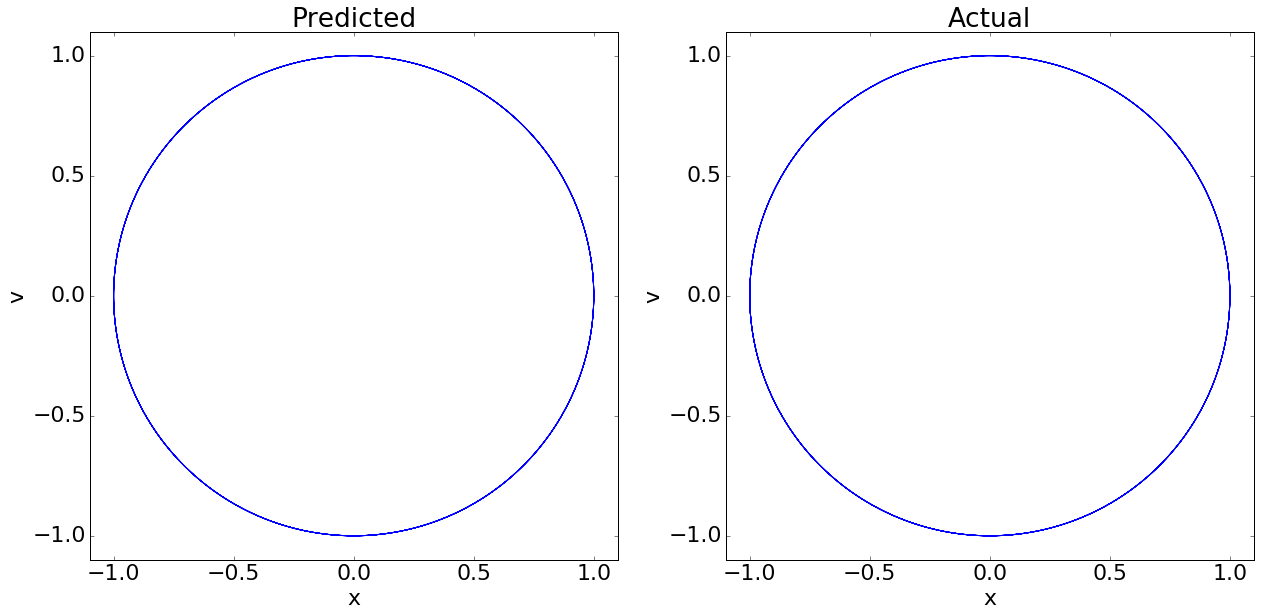

In [349]:
figA, axesA = plt.subplots(nrows=1,ncols=2,figsize=(18,18))
axesA[0].plot(plotX,plotV)
axesA[0].set(adjustable='box-forced', aspect='equal')
axesA[0].set_xlabel('x')
axesA[0].set_ylabel('v')
axesA[0].set_title('Predicted')
axesA[0].set_xlim(min(plotX)-0.1,max(plotX)+0.1)
axesA[0].set_ylim(min(plotV)-0.1,max(plotV)+0.1)
axesA[1].plot(plotAX,plotAV)
axesA[1].set(adjustable='box-forced', aspect='equal')
axesA[1].set_xlabel('x')
axesA[1].set_ylabel('v')
axesA[1].set_title('Actual')
axesA[1].set_xlim(min(plotAX)-0.1,max(plotAX)+0.1)
axesA[1].set_ylim(min(plotAV)-0.1,max(plotAV)+0.1)
figA.tight_layout()
#figA.savefig(str(scheme)+' '+str(nsteps)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' xvSpatial.png')

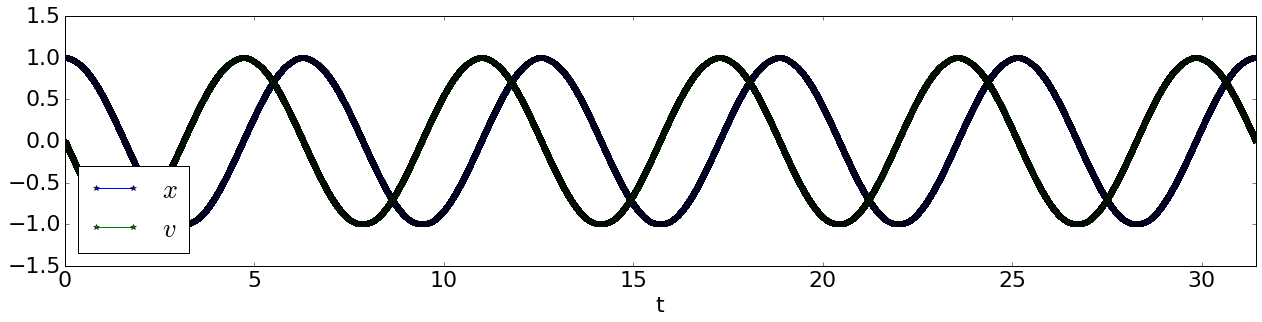

In [350]:
figB, axesB = plt.subplots(figsize=(18,5)) 
axesB.plot(plotT,plotX,'b*-',label='$x$')
axesB.plot(plotT,plotV,'g*-',label='$v$')
axesB.legend(loc=3)
axesB.set_xlabel('t')
axesB.set_xlim(0,timestop)
figB.tight_layout()
#figB.savefig(str(scheme)+' '+str(nsteps)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' xvTime.png')

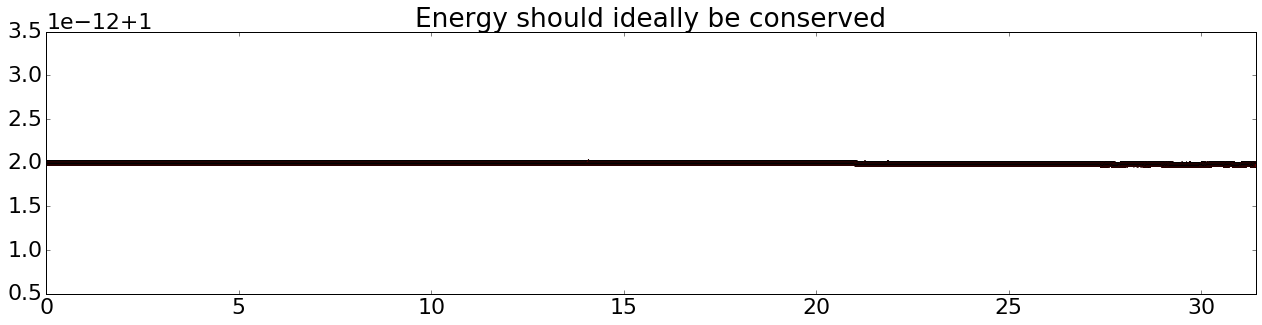

In [351]:
figC, axesC = plt.subplots(figsize=(18,5)) 
axesC.plot(plotT,plotC,'r*-')
axesC.set_title('Energy should ideally be conserved')
axesC.set_xlim(0,timestop)
figC.tight_layout()
#figC.savefig(str(scheme)+' '+str(nsteps)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' nrg.png')

50001 50001


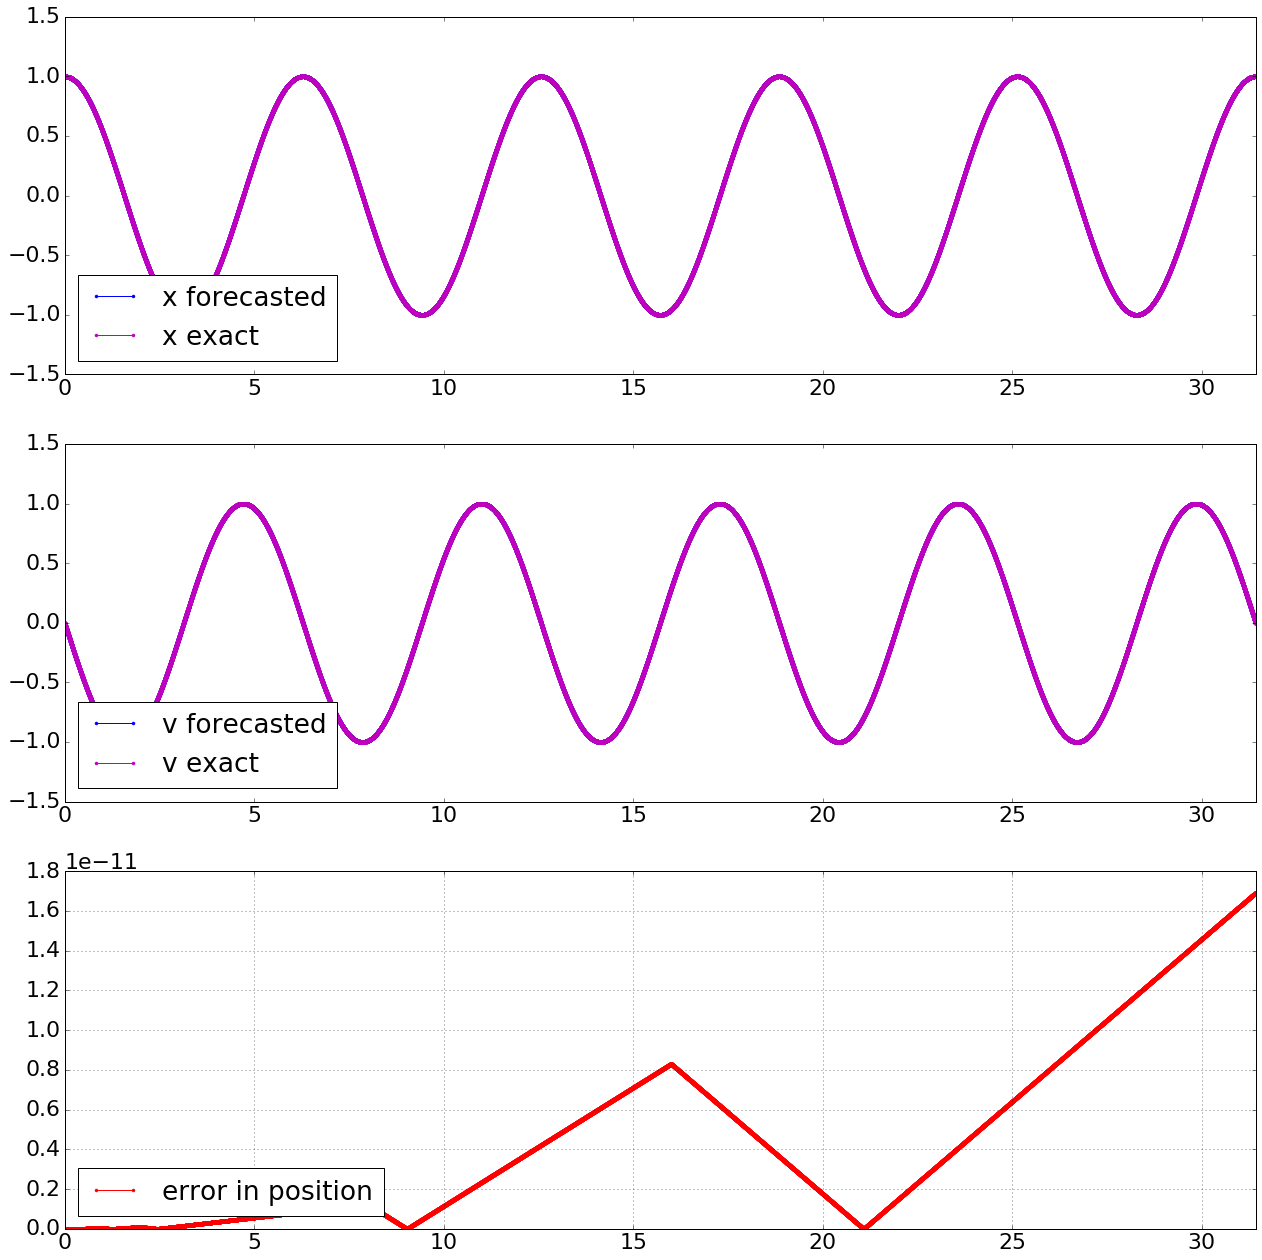

In [352]:
# we can compare with the exact solution, if known
#xe = [math.cos(t) for t in plotT] # exact solution for x(t)
error = [math.sqrt((a-c)**2 + (b-d)**2) for a,b,c,d in zip(plotX,plotV,plotAX,plotAV)]
print (len(error), len(plotT))    
figD, axesD = plt.subplots(nrows=3,ncols=1,figsize=(18,18)) 
axesD[0].plot(plotT,plotX,'b.-',label='x forecasted')
axesD[0].plot(plotT,plotAX,'m.-',label='x exact')
axesD[0].set_xlim(0,timestop)
axesD[0].legend(loc=3)
axesD[1].plot(plotT,plotV,'b.-',label='v forecasted')
axesD[1].plot(plotT,plotAV,'m.-',label='v exact')
axesD[1].set_xlim(0,timestop)
axesD[1].legend(loc=3)
axesD[2].plot(plotT,error,'r.-',label='error in position')
axesD[2].grid()
axesD[2].set_xlim(0,timestop)
axesD[2].legend(loc=3)
figD.tight_layout()
#figD.savefig(str(scheme)+' '+str(nsteps)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' forecastComp.png')

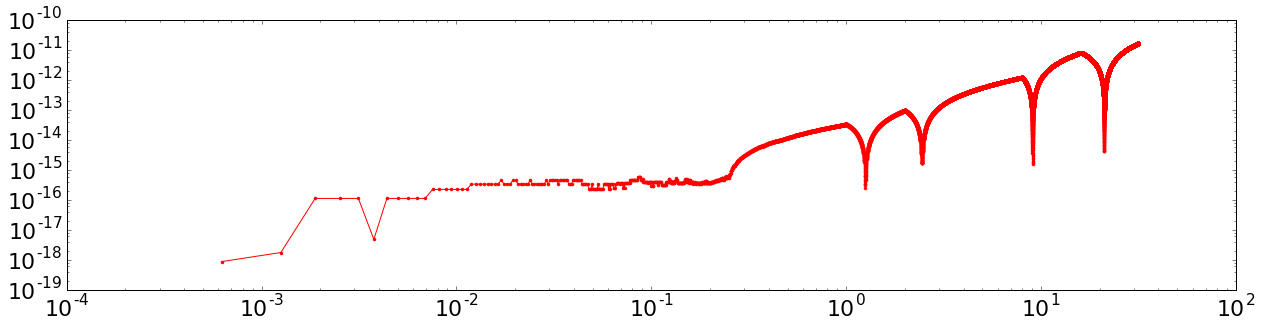

In [353]:
figE, axE = plt.subplots(figsize=(18,5)) 
axE.loglog(plotT,error,'r.-',label='forecast error')
figE.tight_layout()
#figE.savefig(str(scheme)+' '+str(timestep)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' loglogerror.png')

In [354]:
#eulerArr = np.zeros(10)
#fbArr = np.zeros(10)
#lfArr = np.zeros(10)
#rkArr = np.zeros(10)
#stepArr = np.zeros(10)
#ticker = 0

if ticker <= 9:
    eulerArr[ticker] = error[-1]
    stepArr[ticker] = timestep
elif ticker >= 10 and ticker <= 19:
    fbArr[ticker-10] = error[-1]
elif ticker >= 20 and ticker <= 29:
    lfArr[ticker-20] = error[-1]
elif ticker >= 30 and ticker <= 39:
    rkArr[ticker-30] = error[-1]
else:
    print('Too many runs, start again')
ticker+=1
print(eulerArr,fbArr,lfArr,rkArr,stepArr,ticker)

[  1.10074371e+02   6.10423598e+00   1.67921511e+00   9.30112286e-01
   6.37745354e-01   3.89496919e-01   2.79822762e-01   1.03729522e-01
   5.05857692e-02   9.91846848e-03] [ 1.00500968  0.86780278  0.62859918  0.48252689  0.3896882   0.2804039
  0.2186802   0.09398347  0.04815038  0.00982106] [  1.49119979e+07   2.06620370e+03   4.90319541e+01   1.27558480e+01
   6.16786125e+00   2.72380680e+00   1.68182310e+00   4.84070711e-01
   2.18242771e-01   4.02730487e-02] [  2.54683679e-03   6.52737512e-05   4.08010208e-06   8.05963932e-07
   2.55014610e-07   5.03725422e-08   1.59396349e-08   4.06352592e-10
   3.24023977e-11   1.69079853e-11] [ 0.31415927  0.12566371  0.06283185  0.0418879   0.03141593  0.02094395
  0.01570796  0.00628319  0.00314159  0.00062832] 40


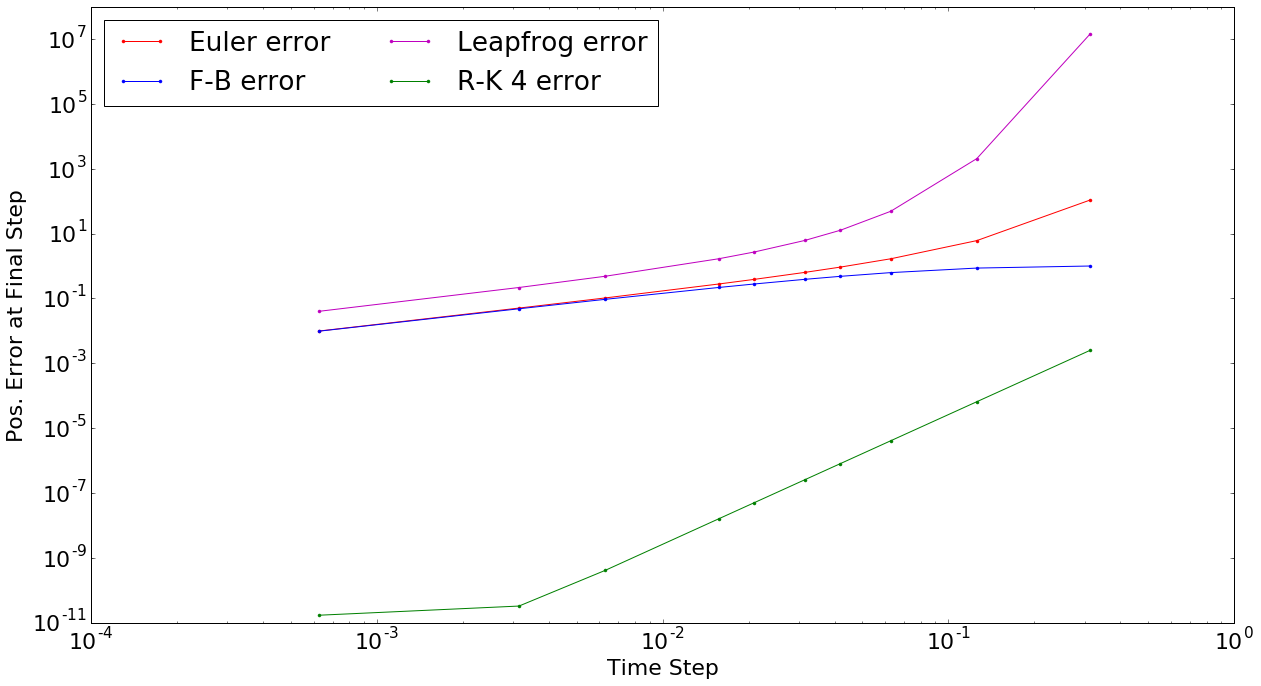

In [404]:
figF, axF = plt.subplots(figsize=(18,10)) 
axF.loglog(stepArr,eulerArr,'r.-',label='Euler error')
axF.loglog(stepArr,fbArr,'b.-',label='F-B error')
axF.loglog(stepArr,lfArr,'m.-',label='Leapfrog error')
axF.loglog(stepArr,rkArr,'g.-',label='R-K 4 error')
axF.legend(loc=0,ncol=2)
axF.set_xlabel('Time Step')
axF.set_ylabel('Pos. Error at Final Step')
figF.tight_layout()
#figF.savefig('Scheme Comparison.png')

In [401]:
slope, intercept = np.polyfit(np.log(stepArr),np.log(eulerArr), 1)
print('Euler Slope shoule be ~ 1')
print('Euler Slope:',slope)
slope, intercept = np.polyfit(np.log(stepArr), np.log(fbArr), 1)
print('Forwards-Backwards Slope shoule be ~ 1')
print('Forwards-Backwards Slope:',slope)
slope, intercept = np.polyfit(np.log(stepArr), np.log(lfArr), 1)
print('Leapfrog Slope shoule be ~ 2')
print('Leapfrog Slope:',slope)
slope, intercept = np.polyfit(np.log(stepArr), np.log(rkArr), 1)
print('Runge-Kutta Slope shoule be ~ 4')
print('Runge-Kutta Slope:',slope)

Euler Slope shoule be ~ 1
Euler Slope: 1.3793581869
Forwards-Backwards Slope shoule be ~ 1
Forwards-Backwards Slope: 0.781838104115
Leapfrog Slope shoule be ~ 2
Leapfrog Slope: 2.70384546073
Runge-Kutta Slope shoule be ~ 4
Runge-Kutta Slope: 3.28024572744


# Slopes from 10 diff time steps

| Scheme | Order |Slope |
| --- | --- | --- |
| Euler Forwards | $1^{st}$ | 1.3793581869 |
| Forwards-Backwards | $1^{st}$ | 0.781838104115 |
| Leapfrog | $2^{nd}$ | 2.70384546073 |
| Runge-Kutta (4-Step) | $4^{th}$ | 3.28024572744 |

### Final Errors for Each Time Step

| Scheme \/ Time Step >| 0.31 | 0.13| 0.063 | 0.042 |  0.031 | 0.021 | 0.016 | 0.0063 | 0.0031 | 0.00063 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Euler Forwards | 110.07 | 6.10 | 1.68 | 0.93 | 0.64 | 0.39 | 0.28 | 0.10 | 0.051 | 0.0099 |
| Forwards-Backwards | 1.01 | 0.88 | 0.63 | 0.48 | 0.39 | 0.28 | 0.22 | 0.094 | 0.048 | 0.0098 |
| Leapfrog | 14911997.9 | 206.62 | 49.03 | 12.76 | 6.17 | 2.72 | 1.68 | 0.48 | 0.22 | 0.040 |
| Runge-Kutta (4-Step) | 0.0025 | 0.000065 | 0.0000041 | 0.00000081 | 0.00000026 | 0.000000050 | 0.000000016 | 0.00000000041 |  0.000000000032 | 0.000000000017 |

### Notes:
Runge-Kutta's slope gets sig. closer to the desired value of 4 when the final time step (50000 steps total) is excluded

Leapfrog's slope gets sig. closer to the deisred value of 2 when the first time step (100 steps total) is excluded

Euler Forwards' slope also gets sig. closer to it's desired value (1) when the first step is excluded

Leapfrog performs worst at all time steps

Euler Forwards and Forwards-Backwards perform similarly at time steps smaller than $10^{-2}$, while F-B performs better at larger time steps

R-K is consistently the most accurate scheme by a significant margin, particularly at larger time steps.